# EEG Cannabis Sleep Consulting Project

## Introduction

Few things are more universally important than sleep. Indeed it features prominantly at the botom of Maslow's famous hierarchy of needs along other non-negotiable parts of life like breathing. Unfortunately, many medical conditions impact patient's ability to sleep, weather by inhibiting sleep onset or by generally reducing sleep quality. The consequences of this sleep deprivation are well documented in the medical and scientific literature. 

One strategy some patients have adopted to mitigate their percieved sleep problems is to self medicate with cannabis. Cannabis, among other side effects, is known to induce calm and even drowsineess in some users. Unfortuantely, due to the controversial political history surrounding this area, little is known quantitatively about the efficacy of such practices. Indeed, it is plausible that while a self-reported drowsiness may occur to some patients, the quality of sleep while under the influence of cannibis may be abnormal or otherwise inferior to unmedicated slep. On the other hand, perhapse for some patient populations use of cannabis may improve quality of sleep and ultimately treat symptomologies that are caused by sleep deprivation as opposed to the physiologic abnormalities underlying their illness. 

The present study seeks to investigate such possibilities, one way or another, in order to justify and direct more systematic clinical investigations. To do so, a patient cohort including adult patients with various psychologic or physiologic coniditions was recruited to sleep with an EEG recording device. Patientis who self medicate with cannabis to aid in sleep, or not, were asked to perform what ever sleep rituals they normally do and to report these activities in a sleep journal associated with the study period. Patient demographics with regard to disease state, cannabis useage, gender, and age were documented by a qualified medical proffessional prior to annonymization of the EEG data. Samples of patient EEG data from these expert defined demographic groupings was then randomely sampled and assessed in an unbiased manner to extract relevant trends. Sleep quality has historically been assessed by comparing sonomnographic features, such as wake after sleep events, time to sleep onset, time in specific sleep phases, and the power of specific neural activity bands at specified cranial locations. These metrics were extracted and assessed in aggregate.

## Methods Daft for Manuscript

Patient data from 1XX sleep trials were recorded under supervision, and annotation of qualified technicians. The patient sleep journals documenting cannibis use or not, as well as relevant demographics were assessed by a qualified medical proffessional prior to annonymization. A table linking electrophysiologic data ID with study relevant demografics was created and stored on a scure Cluster with the anonymyzed electrophysiologic raw data as European Data Format (EDF) files, as well as with xml archives containing technician and machine annotated metadata.

A simple sampling without replacement strategy was implemented to subsample the patient data to create balanced samples of observations from each demographic condition of interest. The anonymous ID for each patient was then used to automatically parse the edf and xml data associated with that patient. The xml data was converted into python dictionaries for easy parsing, and was used to first identify if any technician notes disqualify the patient for technical reasons. This metadata was then used to extract and store the time at which the lights were turned off and on. The edf file was loaded into python with the MNE package. 

After loading the electrophysiology, data was cleaned by downsampling from the original 250 Hz to 100 Hz and bandpass filtering the range from 0.1 to 40 Hz. The YAMA package was then implemented for automatic sleep stage scoring. All four combinations of C3 and C4 located EEG and the two available EMG traces was performed, and the probabilities were average to classify the sleep stage at every 30 second interval. The first time point classified as non-REM level 1 (N1) after the lights were turned off was classified as the initiation of sleep. Meanwhile the amount of time between lights off and sleep onset was stored for each patient.

Data was then subset to include the first, second, third and fourht hour after sleep onset. The amount of time in each stage, as classified by YAMA, was recorded for each of these time periods. The number of wake after sleep events were recorded for each of these time periods. All electrophysiology associated with wake predictions was then removed from the data set for each time period. Using the multitaper spectral estimation of frequency power for 0.1 to 40 Hz a power estimation curve for each time point was produced via the algorithm as implemented in the MNE package with default hyperparameters. The YAMA package was then used to estimate the area under the curve for each electrophysiologically relevant frequency range to estimate band power for each electrode at each time point. These band power estimates were then stored.

After extraction of the relevant statistics from each patient in a group. Interquartile values were computed for each, such that for the relevant statistics the 25th, 50th, and 75th percentile values were recorded for each demographic group. Values were then compared with appropriate data visualizations. Non-parametric statistical tests, such as the Mann Whitney U test were applied to combinations of demographics bearing interest based on these group wise data visualizations. All analysis and data cleaning was performed in python with code available at X.



## Method Explanations in Notebook Form

This notebook contains a broken down version of the full scripting methods. As such each section includes the helper functions called by the main scripting function, with example usage in a global enviorment. The purpose ans structure of this notebook is thus to clearly teach the behavior of each helper function, as well as how they can be used piecemeal in a future project outside of the core script for this manuscript.

### Section 1: Library & Data Loading

The dataset consists of two main file types, an edf trace file consisting of electrophysiology, and a rml containing metadata such as technician notes. Standard python libraries are used for data loading, visualization, and manipulation. Speciailized functions from the MNE library allow for reading and manipulation of the edf data. The main pages for these functions can be found here: 
https://docs.python.org/3/library/os.html
https://mne.tools/stable/index.html

In [1]:
# Library Loading
import mne, os, yasa, pickle
import xml.etree.ElementTree as ET
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

/home/sam/anaconda3/envs/EEG/lib/python3.9/site-packages/numba/core/errors.py:194: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [1]:
def find_largest_x_file(dir_path, x):
    
    # Use glob to find all .rml files in the directory
    files = glob.glob(os.path.join(dir_path, f'*.{x}'))
    
    # Sort files by size in descending order
    files.sort(key=lambda x: os.path.getsize(x), reverse=True)
    
    # Check if any .rml files were found
    if files:
        # Return the largest .rml file found
        return files[0]
    else:
        # Return None or handle the case where no .rml files are found
        return None

def get_namespaces(file_path):
    """
    Parses the XML file and extracts namespaces as a dictionary.
    Namespaces in XML are declared in the root element or throughout the document.
    
    Args:
    - file_path: Path to the XML file.
    
    Returns:
    A dictionary with namespace prefixes as keys and URIs as values.
    """
    namespaces = {}
    for event, elem in ET.iterparse(file_path, events=('start-ns',)):
        prefix, uri = elem
        namespaces[prefix] = uri
    return namespaces

def xml_to_dict(element, namespaces):
    """
    Recursively convert an XML element and its children into a dictionary.
    
    Args:
    - element: The XML element to convert.
    - namespaces: A dictionary of XML namespaces.
    
    Returns:
    A dictionary representation of the XML element.
    """
    # Base case: If the element has no children, return its text content
    # or an empty string if the content is None.
    if not list(element):  # Checks if the element has no children
        return element.text or ''
    
    # Recursion: Convert children into dictionary entries
    element_dict = {}
    for child in element:
        child_tag = child.tag.split('}')[-1]  # Removes the namespace URI if present
        child_dict = xml_to_dict(child, namespaces)  # Recursive call
        
        # Handle cases where tags are repeated by aggregating them into lists
        if child_tag in element_dict:
            if not isinstance(element_dict[child_tag], list):
                # Convert existing entry into a list
                element_dict[child_tag] = [element_dict[child_tag]]
            element_dict[child_tag].append(child_dict)
        else:
            element_dict[child_tag] = child_dict
    
    return element_dict

def convert_rml_to_dict(metadata_path):
    """
    Reads a .rml file, parses it, and converts it into a dictionary.
    
    Args:
    - metadata_path: Path to the .rml file.
    
    Returns:
    A dictionary representing the .rml file's structure.
    """
    # Read and parse the .rml file
    tree = ET.parse(metadata_path)
    root = tree.getroot()

    # Generate namespaces dictionary automatically
    namespaces = get_namespaces(metadata_path)

    # Convert the root XML element to a dictionary
    return xml_to_dict(root, namespaces)

def extract_relevant_annotations(scoring_data):
    # Initialize containers for different types of annotations
    channel_fail_events = []
    comments_with_timestamps = {}
    
    # Check if 'Events' key exists in 'ScoringData'
    if 'Events' in scoring_data and 'Event' in scoring_data['Events']:
        for event in scoring_data['Events']['Event']:
            # Extract ChannelFail events
            if 'ChannelFail' in event and event['ChannelFail']:
                channel_fail_events.append(event['ChannelFail'])
            
            # Extract other comments, like 'Comment' or specific conditions
            # Assume 'timestamp' is the key where the timestamp is stored in each event
            if 'Comment' in event and event['Comment']:
                comment = event['Comment']
                timestamp = event.get('timestamp', 'unknown')  # Provide a default value in case timestamp is missing
                
                # Check if this comment has already been recorded
                if comment in comments_with_timestamps:
                    # Append the new timestamp to the existing list for this comment
                    comments_with_timestamps[comment].append(timestamp)
                else:
                    # Otherwise, start a new list with this timestamp
                    comments_with_timestamps[comment] = [timestamp]
    
    return channel_fail_events, comments_with_timestamps

def stage_plotter(y_pred, t_lightOFF = None, t_lightON = None, invert = False, title_extra=""):
   # Mapping of stages to numeric values
    stage_mapping = {'N3': 0, 'N2': 1, 'N1': 2, 'R': 3, 'W': 4}
    
    # Convert the stages to numeric values using the mapping
    y_mapped = np.array([stage_mapping[stage] for stage in y_pred])
    
    # Create an x-axis array: each point is 30 seconds after the previous
    x_axis = np.arange(len(y_pred)) * 30 / 3600  # Convert seconds to hours
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(x_axis, y_mapped,linestyle='-', color='b', alpha=0.8)
    
    # Add yellow background for specified time periods
    if t_lightOFF is not None:
        plt.axvspan(0, t_lightOFF / 3660, color='yellow', alpha=0.3)  # Before light off
    if t_lightON is not None:
        plt.axvspan(t_lightON / 3660, x_axis[-1], color='yellow', alpha=0.3)  # After light on
    
    # Customizing the axes
    plt.xlabel('Time (hours)')
    plt.ylabel('Sleep Stage')
    plt.xticks(np.arange(0, x_axis[-1] + 1, 1))  # Display only whole number hours
    plt.yticks(np.arange(len(stage_mapping)), list(stage_mapping.keys()))  # Set y-ticks as stage names
    
    # Invert y-axis if specified
    if invert:
        plt.gca().invert_yaxis()  # Invert y-axis to display 'N3' at the top
    
    plt.title('Sleep Stage Over Time ' + title_extra)
    plt.show()

def filter_wake_stages(data, times, y_pred_segment, sfreq):
    """
    Remove data and time points corresponding to "W" stages in y_pred_segment.
    Additionally, returns the filtered y_pred_segment without "W" stages.
    
    Args:
    - data: The data array for the hour.
    - times: The times array for the hour.
    - y_pred_segment: The y_pred array segment for the hour.
    - sfreq: Sampling frequency.
    
    Returns:
    - filtered_data: Data array after removing "W" stages.
    - filtered_times: Times array after removing "W" stages.
    - filtered_y_pred_segment: y_pred_segment array after removing "W" stages.
    """
    # Find indices where y_pred_segment is not "W"
    not_w_indices = np.where(y_pred_segment != 'W')[0]
    
    # Number of samples per 30-second segment
    samples_per_segment = int(30 * sfreq)
    
    # Filter the data and times based on not "W" indices
    filtered_data = np.concatenate([data[:, i*samples_per_segment:(i+1)*samples_per_segment] for i in not_w_indices], axis=1)
    filtered_times = np.concatenate([times[i*samples_per_segment:(i+1)*samples_per_segment] for i in not_w_indices])
    filtered_y_pred_segment = y_pred_segment[not_w_indices]
    
    return filtered_data, filtered_times, filtered_y_pred_segment

def plot_band_powers(subset_dict):
    # Greek symbols for the bands
    bands_greek = ['Δ (Delta)', 'Θ (Theta)', 'Α (Alpha)', 'Σ (Sigma)', 'Β (Beta)', 'Γ (Gamma)']
    bands = ['Delta', 'Theta', 'Alpha', 'Sigma', 'Beta', 'Gamma']

    # Determine the number of channels and time points from the dictionary
    n_times = len(subset_dict)
    n_chans = len(subset_dict[0]['BandPower'])

    # Create a color map for different time points
    colors = plt.cm.viridis(np.linspace(0, 1, n_times))

    # Set up the figure and axes for the subplots
    fig, axs = plt.subplots(n_chans, 1, figsize=(10, n_chans * 3), squeeze=False)
    axs = axs.flatten()  # Flatten the array of axes

    # Plotting each channel in a subplot
    for i in range(n_chans):
        # Retrieve the channel name from the first time point
        chan_name = subset_dict[0]['BandPower'].iloc[i]['Chan']

        for j in range(n_times):
            # Access the DataFrame for the current time and channel
            df = subset_dict[j]['BandPower']
            # Select the row corresponding to the current channel
            row = df.iloc[i]

            # Calculate the offset for grouped bar chart
            bar_width = 0.1  # width of bars
            x = np.arange(len(bands))  # the label locations
            offset = (j - n_times / 2) * bar_width + bar_width / 2

            # Extract the data for the bands
            data = row[bands].values
            # Plot the data on the respective subplot
            axs[i].bar(x + offset, data, bar_width, label=f'Hour {j+1}', color=colors[j])

        axs[i].set_xticks(x)
        axs[i].set_xticklabels(bands_greek)
        axs[i].set_ylabel('Power')
        axs[i].set_title(f'Channel: {chan_name}')
        axs[i].legend(title='Time Point')

    # Adjust the layout so that plots do not overlap
    plt.tight_layout()
    plt.show()

def EEG2Power(data_path, meta_path, 
              channels = ['EEG C3-A2', 'EEG C4-A1', 'EEG O1-A2', 'EEG O2-A1'], 
              fmin = 0.1, fmax = 40, visualize = False):
    # Load the EDF file
    raw = mne.io.read_raw_edf(data_path, preload=True) # data path is the file's location
    # Load the xml meta data
    xml_dict = convert_rml_to_dict(meta_path)
    # Extract Lights off time
    t_lightOFF = xml_dict['Acquisition']['Sessions']['Session']['LightsOff']
    t_lightON = xml_dict['Acquisition']['Sessions']['Session']['LightsOn']
    # Extract commentary in the metadata
    scoring_data = xml_dict.get('ScoringData', {})
    channel_fail_events, other_comments = extract_relevant_annotations(scoring_data)
    # Display the warnings
    print("Channel Fail Events:")
    for event in channel_fail_events:
        print(f"  - {event}")
    print("\nOther Comments:")
    for comment in other_comments:
        print(f"  - {comment}")


    # Predict sleep stage
    sls_dfs = []
    for eeg in ['EEG C3-A2', 'EEG C4-A1']:
        for emg in ['EMG Chin', 'EMG Aux1']:
            sls_i = yasa.SleepStaging(raw, eeg_name=eeg, emg_name=emg)#, metadata=dict(male=male, age = age)
            sls_dfs.append(sls_i.predict_proba())
            if visualize:
                sls_i.plot_predict_proba()

    # Compute the average prediction from this combination of central EEGs and available EMGs
    sls_df = (sls_dfs[0] + sls_dfs[1] + sls_dfs[2] + sls_dfs[3]) / 4
    # Store the predicted annotations
    y_pred = sls_df.idxmax(axis=1).values
    if visualize:
        stage_plotter(y_pred, int(t_lightOFF), int(t_lightON))

    t_0 = int(t_lightOFF) # the time point is in seconds after onset of recording
    
    # Calculate how many intervals to crop from y_pred based on t_0
    # Each interval represents 30 seconds, so t_0 in seconds divided by 30 gives the number of intervals to crop
    intervals_to_crop = int(t_0 / 30)
    y_pred_sleep = y_pred[intervals_to_crop:]
    
    # Find the index of the first instance of 'N1' in the newly trimmed y_pred
    onset_ind = np.where(y_pred_sleep == 'N1')[0][0]
    y_pred_sleep = y_pred_sleep[onset_ind:]
    
    t_lightON2 = int(t_lightON) - t_0 - onset_ind*30
    if visualize:
        stage_plotter(y_pred_sleep, t_lightON = t_lightON2, title_extra="From Sleep Initialization")
    
    
    # Subset to only EEG Channels and print general data
    selected_channels = raw.pick(channels)
    
    # Convert t_0 from seconds to samples to avoid inconsistencies
    sfreq = raw.info['sfreq']  # Sampling frequency
    t_0 = int(t_0 * sfreq)
    
    # Crop the MNE raw object to start from t_0
    raw.crop(tmin=t_0 / sfreq)
    # Use onset_ind to further crop raw and y_pred to start from the first moment of sleep
    # Convert onset_ind back to seconds to use with raw.crop
    onset_seconds = onset_ind * 30  # Each index represents 30 seconds
    # Crop raw to start from the first moment of sleep (the onset of 'N1')
    raw.crop(tmin=onset_seconds)
    
    # Each hour contains 120 intervals of 30 seconds
    intervals_per_hour = 3600 // 30
    sleep_stages = ["W", "R", "N1", "N2", "N3"]
    subset_dict = {}
    for i in range(4):
        t_0 = i*3600
        t_1 = t_0 +3600
        raw_x_hour = raw.copy().crop(tmin=t_0, tmax=t_1)
        data_x_hour, times_x_hour = raw_x_hour[:, :]
        if i ==0:
            y_pred_x = y_pred_sleep[:intervals_per_hour]
        else:
            y_pred_x = y_pred_sleep[intervals_per_hour*i:intervals_per_hour*(i+1)]
         # Initialize the dictionary for this hour
        subset_dict[i] = {
            "data all": data_x_hour,
            "times all": times_x_hour,
            "sls all": y_pred_x
        }
    
        # Count the occurrences of each sleep stage using numpy
        for stage in sleep_stages:
            # Use np.sum to count occurrences of each stage
            subset_dict[i][stage] = np.sum(y_pred_x == stage) * 30  # Multiply by 30 to convert to seconds

    if visualize:
        n_hours = len(subset_dict)
        
        fig, axes = plt.subplots(nrows=1, ncols=n_hours, figsize=(15, 5), sharey=True)
        
        # If there is only one subplot (i.e., one hour), axes will not be an array, so we wrap it in a list
        if n_hours == 1:
            axes = [axes]
        
        for i in range(n_hours):
            times = [subset_dict[i][stage] for stage in sleep_stages]
            axes[i].bar(sleep_stages, times, color=['red', 'orange', 'green', 'blue', 'indigo'])
            axes[i].set_title(f'Hour {i+1}')
            axes[i].set_xlabel('Sleep Stage')
            if i == 0:
                axes[i].set_ylabel('Time Spent (seconds)')
        
        plt.tight_layout()
        plt.show()
        plt.close()

    # Filter wake stages
    for i in range(4):
        subset_dict[i]["data"] , subset_dict[i]["times"], subset_dict[i]["sls"] = filter_wake_stages(subset_dict[i]["data all"] , 
                                                                                                     subset_dict[i]["times all"], 
                                                                                                     subset_dict[i]["sls all"], sfreq)
        if visualize:
            stage_plotter(subset_dict[i]["sls"], title_extra=f"No wake hour {i+1}")
    
    
    # Compute PSD for the each hour
    for i in range(4):
        subset_dict[i]["PSD"] , subset_dict[i]["PSD Freqs"],=  mne.time_frequency.psd_array_multitaper(subset_dict[i]["data"],
                                                                     sfreq=sfreq, fmin=fmin, fmax=fmax, adaptive=False, 
                                                                     normalization='length', verbose=True)
    
    n_hours = len(subset_dict)
    n_channels = len(channels)
    
    # Preinitialize zero vectors for normalized PSDs for all hours
    normalized_psds = [np.zeros_like(subset_dict[hour]["PSD"]) for hour in range(n_hours)]

    # compute and store bandpower
    for j in range(n_hours):
        bp_df = []
        freqs = subset_dict[j]["PSD Freqs"]  # Accessing the frequency values
        for i, channel in enumerate(channels):
            psd = subset_dict[j]["PSD"][i]  # Accessing the PSD for the current channel
            bp_df.append(yasa.bandpower_from_psd(psd, freqs, ch_names=channel))
        subset_dict[j]["BandPower"] = pd.concat(bp_df, ignore_index=True)  # Use ignore_index=True to reset the index
        if visualize:
            display(subset_dict[j]["BandPower"])
    if visualize:
        # Example of how to plot these tabeles:
        plot_band_powers(subset_dict)
    
    # Normalize the PSDs across all hours for each channel
    for i in range(n_channels):  # Iterate over each channel
        # Find the maximum PSD value for the current channel across all hours
        max_value = max(np.max(subset_dict[hour]["PSD"][i]) for hour in range(n_hours))
        
        # Normalize the PSD values by the maximum value for each hour
        for hour in range(n_hours):
            normalized_psds[hour][i] = subset_dict[hour]["PSD"][i] / max_value

    if visualize:
        # Setup the figure and axes for n_channels rows and 1 column
        fig, axes = plt.subplots(nrows=n_channels, ncols=1, figsize=(10, 12), sharex='all', sharey='row')
        if n_channels == 1:
            axes = [axes]  # Make sure axes is iterable for a single channel case
        
        for i, channel in enumerate(channels):
            # Plot the normalized PSD for each hour, overlaying them
            for hour in range(n_hours):
                freqs = subset_dict[hour]["PSD Freqs"]
                axes[i].semilogy(freqs, normalized_psds[hour][i].T, label=f'Hour {hour+1}', alpha=0.5)
            
            # Set plot attributes
            axes[i].set_xlabel('Frequency (Hz)')
            axes[i].set_ylabel('Normalized PSD')
            axes[i].set_title(channel)
            axes[i].set_xlim([0.1, 40])
            axes[i].legend()
        
        plt.tight_layout()
        plt.show()

    
    return {"Freqs" : freqs,
           "PSDs" : normalized_psds,
            "Hours" : subset_dict,
           "Time2Sleep" : onset_seconds}

Extracting EDF parameters from /home/sam/Classes/Stats/Consulting/EEG_Consulting/Examples2024/00000016-APDx20974/00000016-APDx20974[001].edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9235599  =      0.000 ... 46177.995 secs...


/tmp/ipykernel_15369/3285419208.py:212: RuntimeWarning: Channel names are not unique, found duplicates for: {'Flow Patient'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(data_path, preload=True) # data path is the file's location


Channel Fail Events:

Other Comments:
  - possible premayure beat
  - possible premature beat
  - premature beats
  - quadrigeminy
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/home/sam/anaconda3/envs/EEG/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/home/sam/anaconda3/envs/EEG/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/home/sam/anaconda3/envs/EEG/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/home/sam/anaconda3/envs/EEG/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


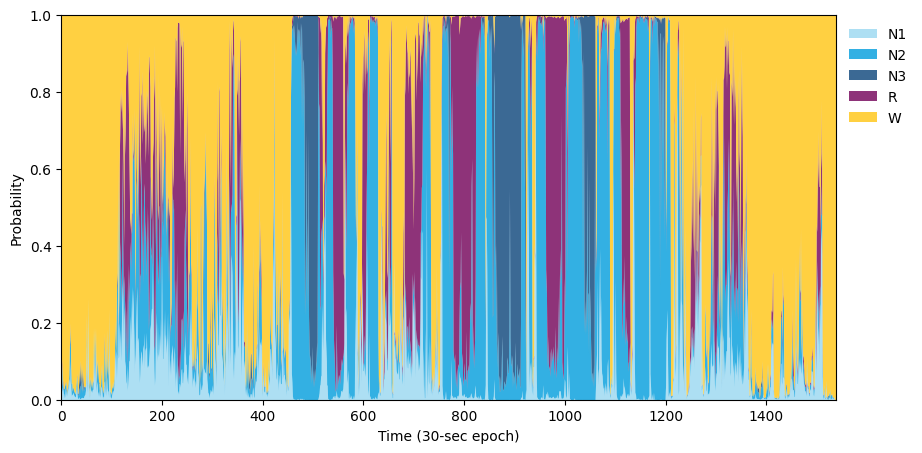

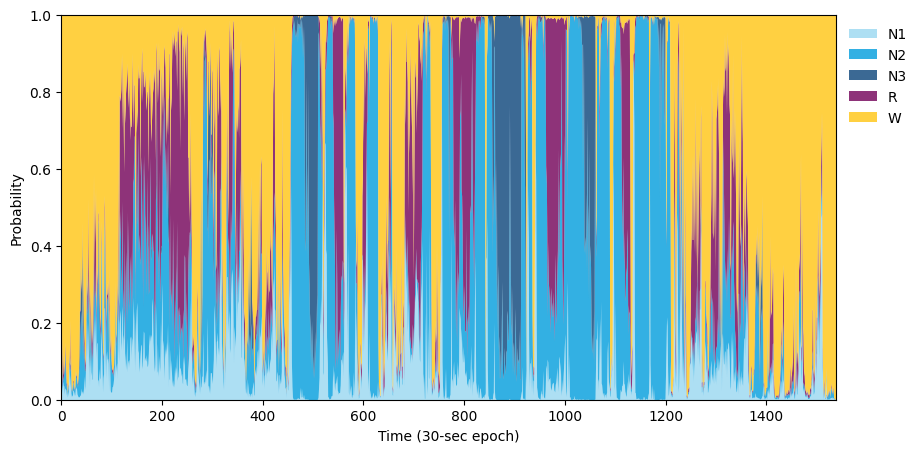

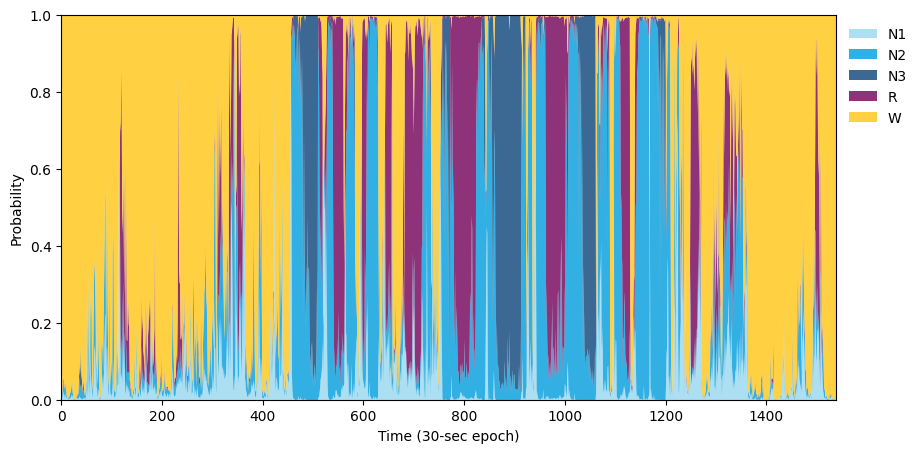

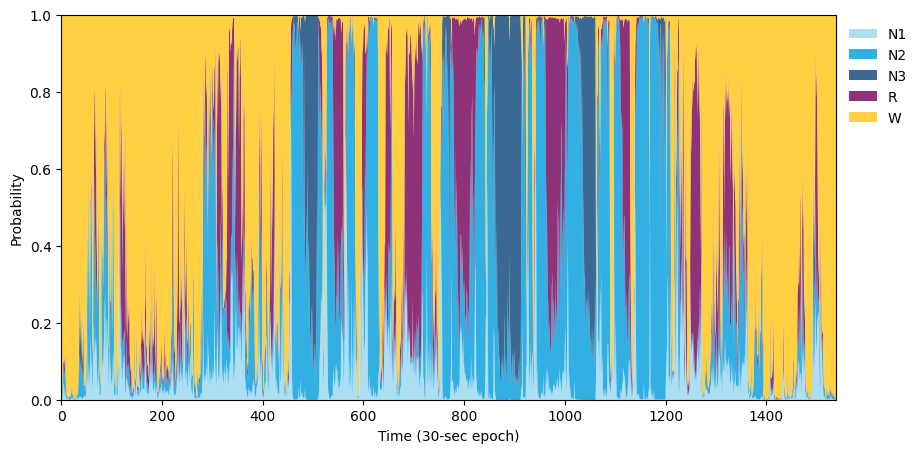

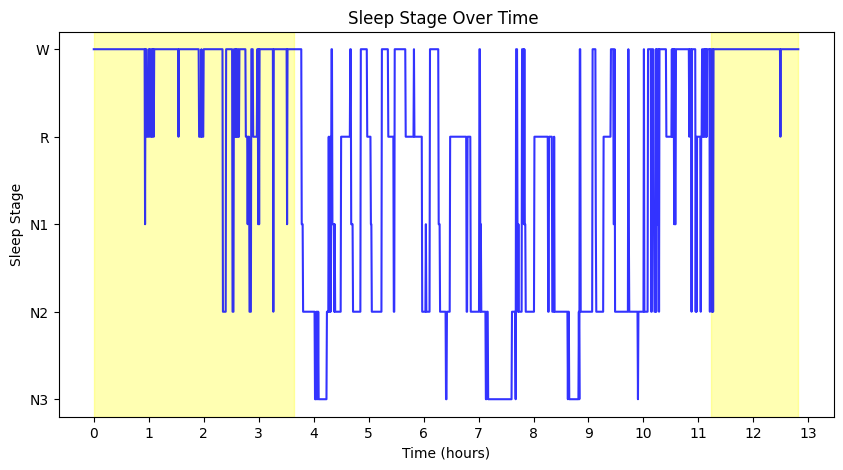

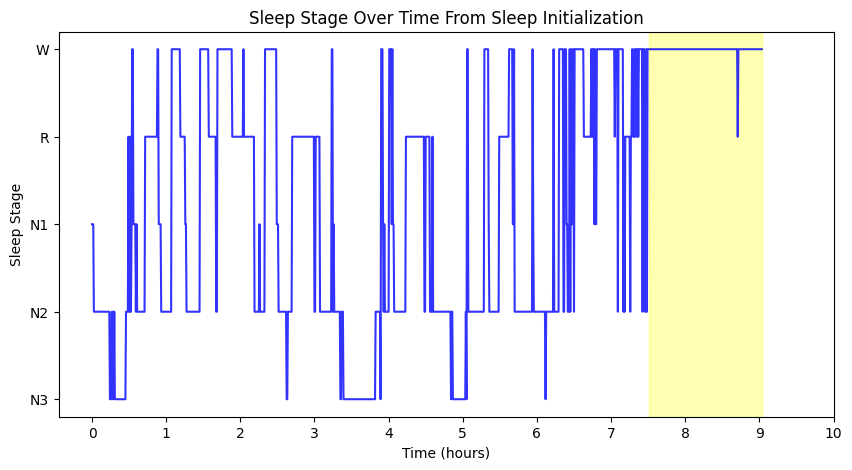

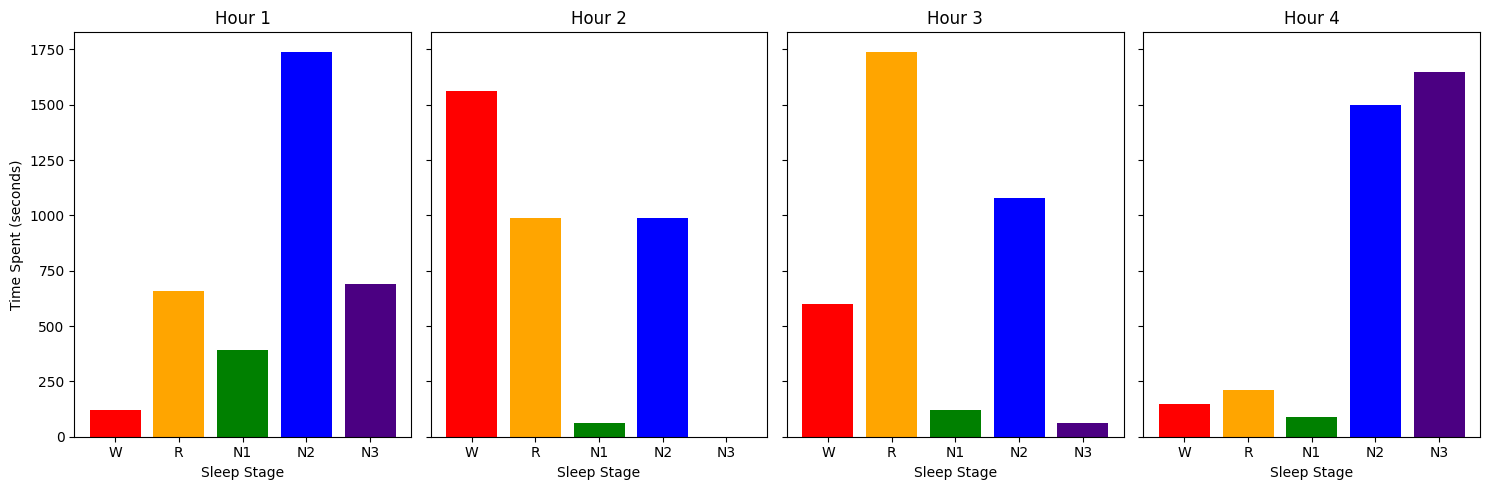

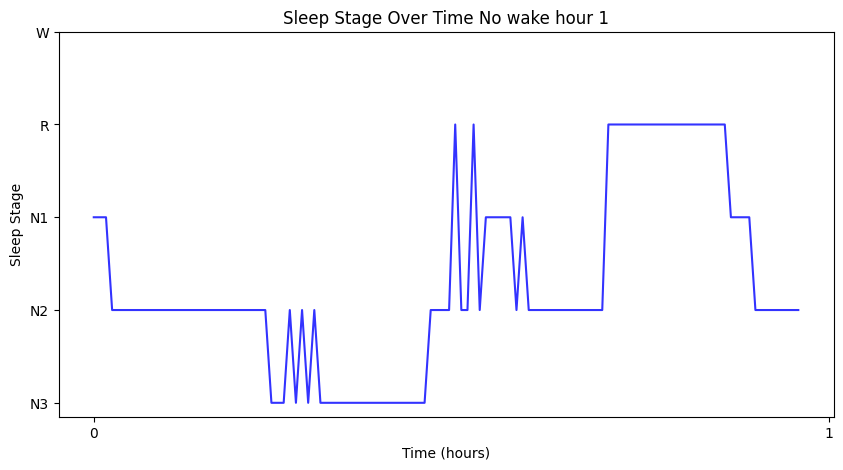

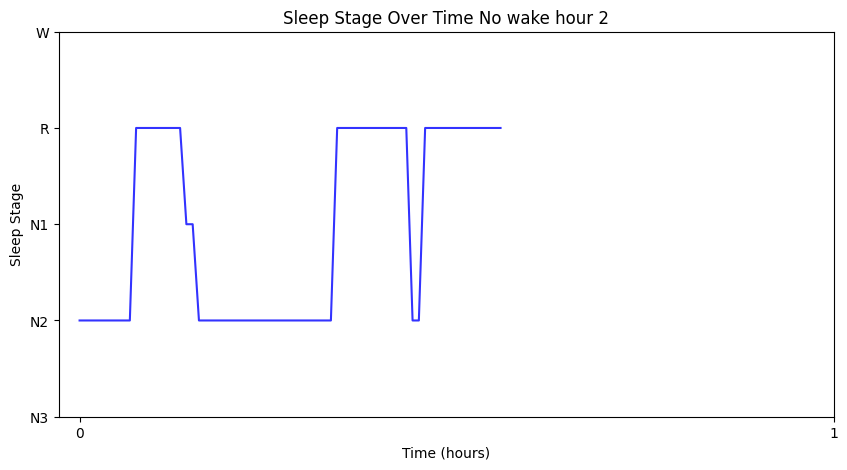

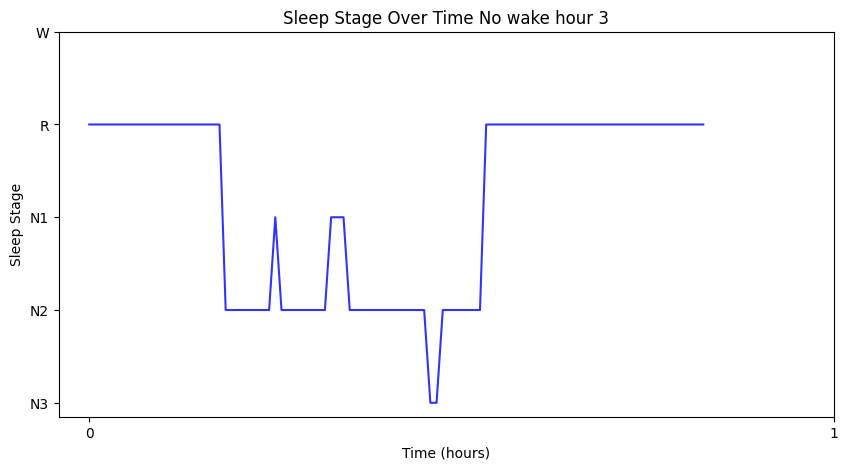

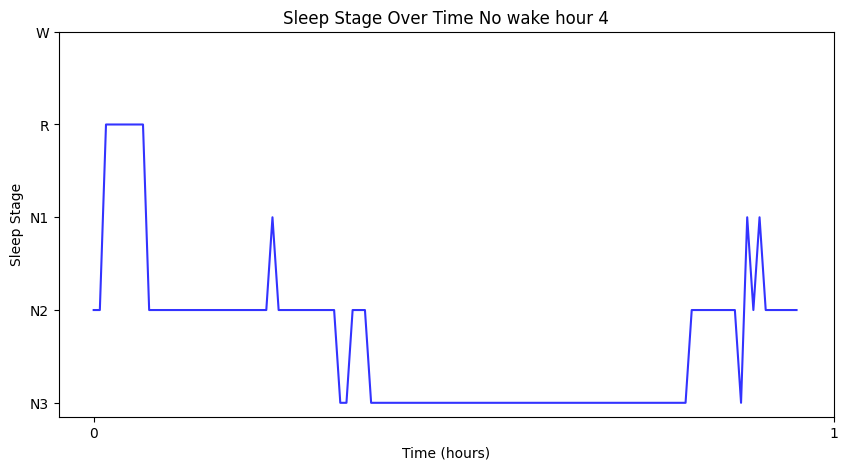

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


,Chan,Delta,Theta,Alpha,Sigma,Beta,Gamma,TotalAbsPow,FreqRes,Relative
0,EEG C3-A2,0.836194,0.077079,0.046082,0.022708,0.015440,0.002496,5.601057e-08,0.000287,True
1,EEG C4-A1,0.824961,0.080417,0.051585,0.023161,0.016733,0.003142,5.316495e-08,0.000287,True
2,EEG O1-A2,0.830353,0.113588,0.028940,0.013248,0.011566,0.002305,5.937454e-08,0.000287,True
3,EEG O2-A1,0.891339,0.045058,0.025677,0.015914,0.017967,0.004045,3.219389e-08,0.000287,True


,Chan,Delta,Theta,Alpha,Sigma,Beta,Gamma,TotalAbsPow,FreqRes,Relative
0,EEG C3-A2,0.782782,0.082141,0.059552,0.032650,0.032843,0.010031,3.655558e-08,0.00049,True
1,EEG C4-A1,0.819798,0.069130,0.050390,0.026969,0.026397,0.007316,4.041104e-08,0.00049,True
2,EEG O1-A2,0.869182,0.086372,0.022712,0.009713,0.009560,0.002461,7.926035e-08,0.00049,True
3,EEG O2-A1,0.894910,0.035438,0.024646,0.016859,0.022071,0.006076,3.454395e-08,0.00049,True


,Chan,Delta,Theta,Alpha,Sigma,Beta,Gamma,TotalAbsPow,FreqRes,Relative
0,EEG C3-A2,0.838140,0.072547,0.039675,0.023617,0.021214,0.004807,4.105423e-08,0.000333,True
1,EEG C4-A1,0.849144,0.067205,0.037306,0.020620,0.020406,0.005320,4.596184e-08,0.000333,True
2,EEG O1-A2,0.872117,0.094894,0.016837,0.008145,0.006335,0.001672,8.233043e-08,0.000333,True
3,EEG O2-A1,0.949905,0.019016,0.011445,0.007935,0.009474,0.002224,6.338239e-08,0.000333,True


,Chan,Delta,Theta,Alpha,Sigma,Beta,Gamma,TotalAbsPow,FreqRes,Relative
0,EEG C3-A2,0.885715,0.053951,0.036446,0.013157,0.008730,0.002021,8.770656e-08,0.00029,True
1,EEG C4-A1,0.914114,0.041301,0.026950,0.008695,0.007463,0.001531,1.243500e-07,0.00029,True
2,EEG O1-A2,0.879374,0.079887,0.022699,0.010363,0.006272,0.001407,1.062342e-07,0.00029,True
3,EEG O2-A1,0.936085,0.033780,0.011610,0.006641,0.009660,0.002236,6.989724e-08,0.00029,True


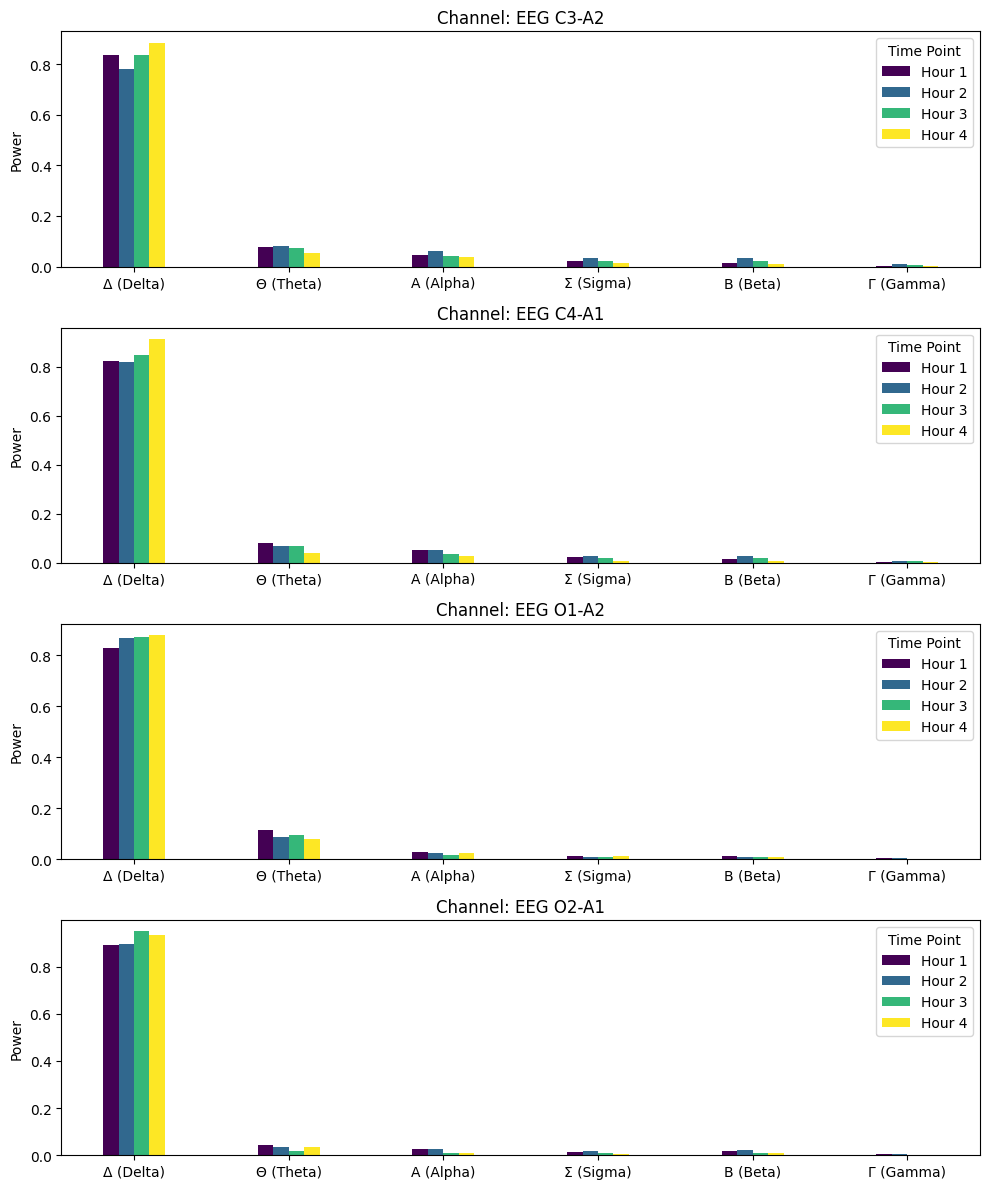

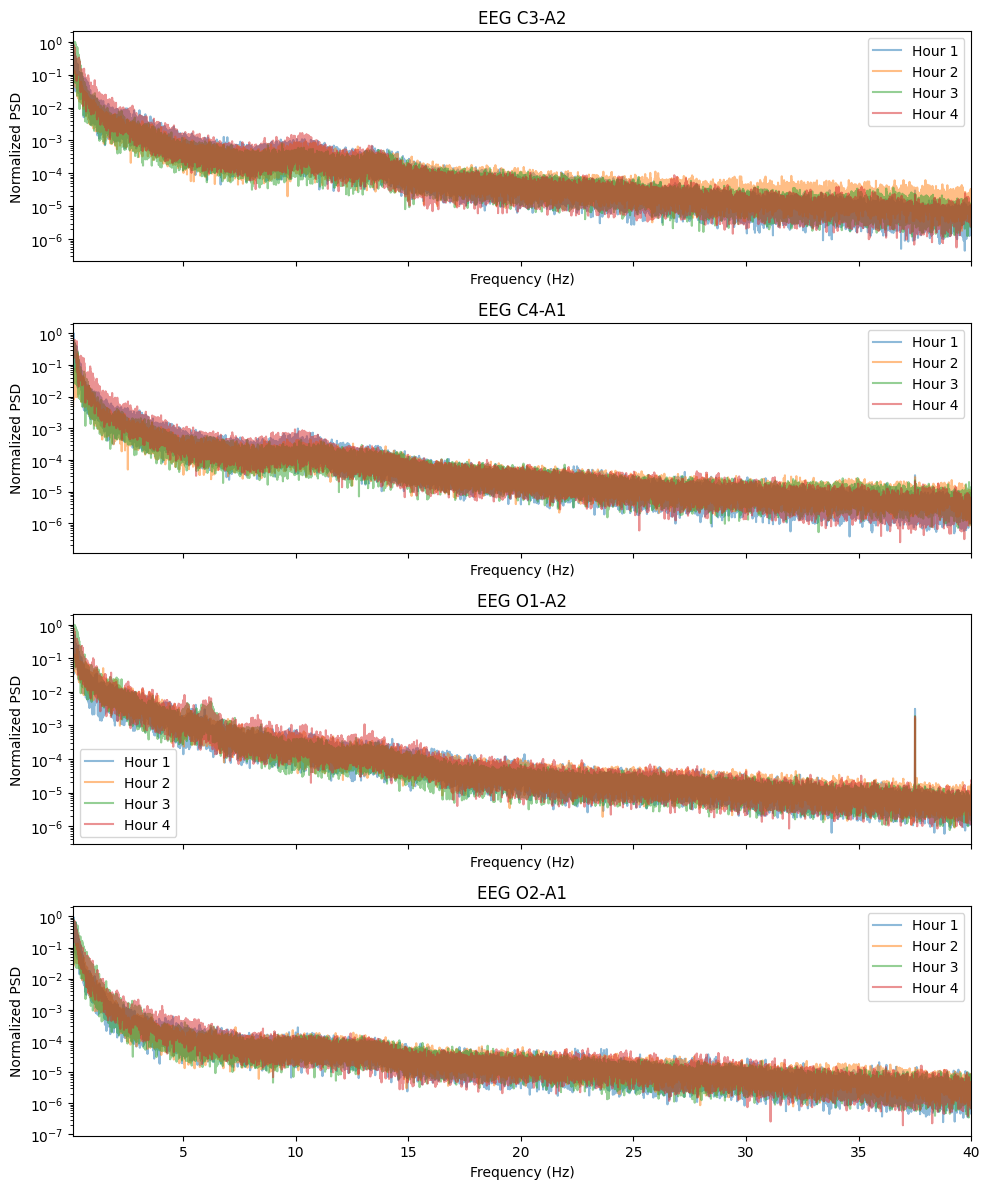

In [3]:
data_root = os.path.join(os.getcwd(), 'Examples2024', '00000016-APDx20974') # this is an example participant ID
data_path = os.path.join(data_root, '00000016-APDx20974[001].edf')
meta_path = os.path.join(data_root, '00000016-APDx20974.rml')

# Example Useage
Normalized_dict = EEG2Power(data_path, meta_path, 
                              channels = ['EEG C3-A2', 'EEG C4-A1', 'EEG O1-A2', 'EEG O2-A1'], 
                              fmin = 0.1, fmax = 40, visualize = True)

In [6]:
import os, glob
data_root = os.path.join(os.getcwd(), 'MJCohortG3') 
# read subdirectory names in data_root
ids = [name for name in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, name))]

# Compute statistics and store each pickle
for subject_id in ids:
    dir_path = os.path.join(data_root, subject_id)
    data_path = find_largest_x_file(dir_path, 'edf')
    print(data_path)

/home/sam/Classes/Stats/Consulting/EEG_Consulting/MJCohortG3/NJF0155/NJF0155.edf.edf
None
/home/sam/Classes/Stats/Consulting/EEG_Consulting/MJCohortG3/NJE0311/NJE0311.edf.edf
/home/sam/Classes/Stats/Consulting/EEG_Consulting/MJCohortG3/NJG1897/00000233-APDx20067[001]-T.edf
/home/sam/Classes/Stats/Consulting/EEG_Consulting/MJCohortG3/NJE0500/NJE0500.edf.edf
/home/sam/Classes/Stats/Consulting/EEG_Consulting/MJCohortG3/NJC1222/NJC1222.edf.edf
/home/sam/Classes/Stats/Consulting/EEG_Consulting/MJCohortG3/NJC5233/NJC5233.edf.edf
/home/sam/Classes/Stats/Consulting/EEG_Consulting/MJCohortG3/NJG0124/NJG0124.edf.edf
/home/sam/Classes/Stats/Consulting/EEG_Consulting/MJCohortG3/NJC0102/NJC0102.edf.edf
/home/sam/Classes/Stats/Consulting/EEG_Consulting/MJCohortG3/NJF0141/NJF0141.edf.edf
None
None
None
/home/sam/Classes/Stats/Consulting/EEG_Consulting/MJCohortG3/NJG0052/NJG0052.edf.edf
/home/sam/Classes/Stats/Consulting/EEG_Consulting/MJCohortG3/NJD5222/NJD5222.edf.edf
/home/sam/Classes/Stats/Consult

Output: 

Output: 

To viaulize the results of the multitaper spectra one can now use matplotlib directly as demonstrated below.

In [4]:
import matplotlib.pyplot as plt

def plot_band_powers(subset_dict):
    # Greek symbols for the bands
    bands_greek = ['Δ (Delta)', 'Θ (Theta)', 'Α (Alpha)', 'Σ (Sigma)', 'Β (Beta)', 'Γ (Gamma)']
    bands = ['Delta', 'Theta', 'Alpha', 'Sigma', 'Beta', 'Gamma']

    # Determine the number of channels and time points from the dictionary
    n_times = len(subset_dict)
    n_chans = len(subset_dict[0]['BandPower'])

    # Create a color map for different time points
    colors = plt.cm.viridis(np.linspace(0, 1, n_times))

    # Set up the figure and axes for the subplots
    fig, axs = plt.subplots(n_chans, 1, figsize=(10, n_chans * 3), squeeze=False)
    axs = axs.flatten()  # Flatten the array of axes

    # Plotting each channel in a subplot
    for i in range(n_chans):
        # Retrieve the channel name from the first time point
        chan_name = subset_dict[0]['BandPower'].iloc[i]['Chan']

        for j in range(n_times):
            # Access the DataFrame for the current time and channel
            df = subset_dict[j]['BandPower']
            # Select the row corresponding to the current channel
            row = df.iloc[i]

            # Calculate the offset for grouped bar chart
            bar_width = 0.1  # width of bars
            x = np.arange(len(bands))  # the label locations
            offset = (j - n_times / 2) * bar_width + bar_width / 2

            # Extract the data for the bands
            data = row[bands].values
            # Plot the data on the respective subplot
            axs[i].bar(x + offset, data, bar_width, label=f'Hour {j+1}', color=colors[j])

        axs[i].set_xticks(x)
        axs[i].set_xticklabels(bands_greek)
        axs[i].set_ylabel('Power')
        axs[i].set_title(f'Channel: {chan_name}')
        axs[i].legend(title='Time Point')

    # Adjust the layout so that plots do not overlap
    plt.tight_layout()
    plt.show()

for j in range(n_hours):
    bp_df = []
    freqs = subset_dict[j]["PSD Freqs"]  # Accessing the frequency values
    for i, channel in enumerate(channels):
        psd = subset_dict[j]["PSD"][i]  # Accessing the PSD for the current channel
        bp_df.append(yasa.bandpower_from_psd(psd, freqs, ch_names=channel))
    subset_dict[j]["BandPower"] = pd.concat(bp_df, ignore_index=True)  # Use ignore_index=True to reset the index
    display(subset_dict[j]["BandPower"])

# Example of how to plot these tabeles:
plot_band_powers(subset_dict)

NameError: name 'n_hours' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

n_hours = len(subset_dict)
n_channels = len(channels)

# Preinitialize zero vectors for normalized PSDs for all hours
normalized_psds = [np.zeros_like(subset_dict[hour]["PSD"]) for hour in range(n_hours)]

# Normalize the PSDs across all hours for each channel
for i in range(n_channels):  # Iterate over each channel
    # Find the maximum PSD value for the current channel across all hours
    max_value = max(np.max(subset_dict[hour]["PSD"][i]) for hour in range(n_hours))
    
    # Normalize the PSD values by the maximum value for each hour
    for hour in range(n_hours):
        normalized_psds[hour][i] = subset_dict[hour]["PSD"][i] / max_value

# Setup the figure and axes for n_channels rows and 1 column
fig, axes = plt.subplots(nrows=n_channels, ncols=1, figsize=(10, 12), sharex='all', sharey='row')
if n_channels == 1:
    axes = [axes]  # Make sure axes is iterable for a single channel case

for i, channel in enumerate(channels):
    # Plot the normalized PSD for each hour, overlaying them
    for hour in range(n_hours):
        freqs = subset_dict[hour]["PSD Freqs"]
        axes[i].semilogy(freqs, normalized_psds[hour][i].T, label=f'Hour {hour+1}', alpha=0.5)
    
    # Set plot attributes
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('Normalized PSD')
    axes[i].set_title(channel)
    axes[i].set_xlim([0.1, 40])
    axes[i].legend()

plt.tight_layout()
plt.show()


In [ ]:


# Example Useage
Normalized_dict = EEG2Power(data_path, meta_path, 
                              channels = ['EEG C3-A2', 'EEG C4-A1', 'EEG O1-A2', 'EEG O2-A1'], 
                              fmin = 0.1, fmax = 40, visualize = True)

In [7]:
import os, glob
data_root = os.path.join(os.getcwd(), 'MJCohortG3') 
# read subdirectory names in data_root
ids = [name for name in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, name))]

# Compute statistics and store each pickle
pickle_shop = []
for subject_id in ids:
    dir_path = os.path.join(data_root, subject_id)
    data_path = find_largest_x_file(dir_path, 'edf')
    meta_path = find_largest_x_file(dir_path, 'rml')
    try:
        Normalized_dict = EEG2Power(data_path, meta_path, 
                                      channels = ['EEG C3-A2', 'EEG C4-A1', 'EEG O1-A2', 'EEG O2-A1'], 
                                      fmin = 0.1, fmax = 40, visualize = False)
        # pickle Normalized_dict dictionary
        pickle_name = os.path.join(data_root, f'{subject_id}.pkl')
        with open(pickle_name, 'wb') as pickle_file:
            pickle.dump(Normalized_dict, pickle_file)
        pickle_shop.append(pickle_name)
    except:
        print(f'Problem detected with {data_path}')

print("Processing and pickling completed for all subjects.")

Problem detected with /home/sam/Classes/Stats/Consulting/EEG_Consulting/MJCohortG3/NJF0155/NJF0155.edf.edf
Problem detected with None
Problem detected with /home/sam/Classes/Stats/Consulting/EEG_Consulting/MJCohortG3/NJE0311/NJE0311.edf.edf
Problem detected with /home/sam/Classes/Stats/Consulting/EEG_Consulting/MJCohortG3/NJG1897/00000233-APDx20067[001]-T.edf
Problem detected with /home/sam/Classes/Stats/Consulting/EEG_Consulting/MJCohortG3/NJE0500/NJE0500.edf.edf
Problem detected with /home/sam/Classes/Stats/Consulting/EEG_Consulting/MJCohortG3/NJC1222/NJC1222.edf.edf
Problem detected with /home/sam/Classes/Stats/Consulting/EEG_Consulting/MJCohortG3/NJC5233/NJC5233.edf.edf
Problem detected with /home/sam/Classes/Stats/Consulting/EEG_Consulting/MJCohortG3/NJG0124/NJG0124.edf.edf
Problem detected with /home/sam/Classes/Stats/Consulting/EEG_Consulting/MJCohortG3/NJC0102/NJC0102.edf.edf
Problem detected with /home/sam/Classes/Stats/Consulting/EEG_Consulting/MJCohortG3/NJF0141/NJF0141.edf.

In [64]:
pickle_files = [f for f in os.listdir(data_root) if f.endswith('.pkl')]

# Initialize a dictionary to store the loaded data
loaded_data = {}

# Loop over each pickle file and load its contents
for pickle_file in pickle_files:
    file_path = os.path.join(data_root, pickle_file)
    with open(file_path, 'rb') as file:
        # Load the pickle file content and store it in the dictionary
        loaded_data[pickle_file[:-4]] = pickle.load(file)

# Now you can access the loaded data from the dictionary
print("Loaded data from pickle files:")
def wake_events(data, time_point):
    """
    Counts the transitions from False to True in a given list of booleans.

    :param data: list of booleans
    :return: count of False to True transitions
    """
    data = data['Hours'][time_point]['sls all'] == 'W'
    count = 0
    # Iterate over the list from the second element to the end
    for i in range(1, len(data)):
        # Check if the current value is True and the previous value is False
        if data[i] and not data[i - 1]:
            count += 1
    return count

for key in loaded_data.keys():
    print(f"Patient {key} initiated sleep {loaded_data[key]['Time2Sleep']} seconds after lights off")
    for i in range(4):
        for stage in sleep_stages:
            print(f"In hour {i} they were in sleep stage {stage} for {loaded_data[key]['Hours'][i][stage]} seconds")
            if stage == 'W':
                print(f'Of this time, there were {wake_events(loaded_data[key], 0)} unique wake events predicted')
    print('\n'*3)

Loaded data from pickle files:
Patient 00000057-APDx20067 initiated sleep 930 seconds after lights off
In hour 0 they were in sleep stage W for 2940 seconds
Of this time, there were 11 unique wake events predicted
In hour 0 they were in sleep stage R for 90 seconds
In hour 0 they were in sleep stage N1 for 360 seconds
In hour 0 they were in sleep stage N2 for 210 seconds
In hour 0 they were in sleep stage N3 for 0 seconds
In hour 1 they were in sleep stage W for 2850 seconds
Of this time, there were 11 unique wake events predicted
In hour 1 they were in sleep stage R for 180 seconds
In hour 1 they were in sleep stage N1 for 150 seconds
In hour 1 they were in sleep stage N2 for 420 seconds
In hour 1 they were in sleep stage N3 for 0 seconds
In hour 2 they were in sleep stage W for 2790 seconds
Of this time, there were 11 unique wake events predicted
In hour 2 they were in sleep stage R for 0 seconds
In hour 2 they were in sleep stage N1 for 120 seconds
In hour 2 they were in sleep stage

Notes: 

We are missing a few functions because we had to show Dr. Kinney what we had done so far and get input based on how we were approaching the problem before we had everything we need. 

There is also potential that we need to implement another function that can filter out unwanted time segments in the data. Unwanted time segments could include times when the participant woke up during the night, for example. We are waiting to hear if these times have been removed from the data or not, and will proceed based on the response. 